In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install packages that we need --- from https://colab.research.google.com/drive/1-aOfk6mVFUA3PH_s6P-lCaM9xKLJ0dLz?usp=sharing#scrollTo=laBJ-Yj78O0m
%%capture
#!pip install numpy
!pip install sentencepiece
!pip install transformers
!pip install sentence-transformers
!pip install umap-learn
!pip install altair --upgrade -U
!pip install pyarrow==11.0.0
!pip install --upgrade --no-cache-dir gdown

In [ ]:
# Import packages

# For downloading data
import gdown
# For working with JSON files
import json
# For working with LMs
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
import numpy as np
import pandas as pd
import operator
# For printing long documents
import textwrap
# For status bars
from tqdm.notebook import tqdm
# For dimensionality reduction
import umap.umap_ as umap
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [ ]:
from random import sample

import nltk
nltk.download('punkt')

from scipy.stats import pearsonr, ttest_ind

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from  matplotlib.ticker import FuncFormatter

In [ ]:
# Load/initialize ST5 model
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

## Section 1: Cleaning Data ##

In [ ]:
cn_fm_df = pd.read_excel("/content/drive/My Drive/2023-24/Academics/Research/Corpus/Files/CMFA_PressCon_v4.xlsx", engine="openpyxl") #https://stackoverflow.com/questions/57817758/badzipfile-file-is-not-a-zip-file-error-popped-up-all-of-a-sudden
fm_trim_df = cn_fm_df[["date", "year", "question", "answer", "question_lem", "answer_lem", "a_sentiment", "q_sentiment"]]
print(fm_trim_df.shape)
fm_trim_df.head()

(30964, 8)


date  year  \
0  2002-10-15 00:00:00  2002   
1  2002-10-15 00:00:00  2002   
2  2002-10-15 00:00:00  2002   
3  2002-10-15 00:00:00  2002   
4  2002-10-15 00:00:00  2002   

                                            question  \
0  How many Hong Kong and Taiwan people were inju...   
1  Today, five Japanese who were kidnapped by the...   
2  Recently Nepal formed an interim government. H...   
3  Pakistan held the general election on 10 Octob...   
4  Is China concerned about the rise of the funda...   

                                              answer  \
0  China is always opposed to terrorism of all fo...   
1  Both DPRK and Japan are close neighbors of Chi...   
2  The Chinese Government would like to express c...   
3  As a friendly neighbor of Pakistan, we rejoice...   
4  I have said that we are glad to see the smooth...   

                                        question_lem  \
0  how many Hong Kong and Taiwan people be injure...   
1  today, five japanese who be kidnap by the Nort...   
2  recently Nepal form a interim government. how ...   
3  Pakistan hold the general election on 10 Octob...   
4  be China concerned about the rise of the funda...   

                                          answer_lem  a_sentiment  q_sentiment  
0  China be always opposed to terrorism of all fo...     2.354945     0.939969  
1  both DPRK and Japan be close neighbor of China...     5.112201     2.474082  
2  the chinese Government would like to express c...     4.926227     3.039821  
3  as a friendly neighbor of Pakistan, we rejoice...     5.282908     2.699500  
4  I have say that we be glad to see the smooth g...     5.174895     2.123604

In [ ]:
cn_fm_df.head()

id_orig id_split  id                                               link  \
0        1        1   1  http://web.archive.org/web/20030907084940/http...   
1        2        2   2  http://web.archive.org/web/20030907084940/http...   
2        3        3   3  http://web.archive.org/web/20030907084940/http...   
3        4        4   4  http://web.archive.org/web/20030907084940/http...   
4        5        5   5  http://web.archive.org/web/20030907084940/http...   

  spokesperson day    month  year                 date  \
0  Zhang Qiyue  15  October  2002  2002-10-15 00:00:00   
1  Zhang Qiyue  15  October  2002  2002-10-15 00:00:00   
2  Zhang Qiyue  15  October  2002  2002-10-15 00:00:00   
3  Zhang Qiyue  15  October  2002  2002-10-15 00:00:00   
4  Zhang Qiyue  15  October  2002  2002-10-15 00:00:00   

                                            question  ...  \
0  How many Hong Kong and Taiwan people were inju...  ...   
1  Today, five Japanese who were kidnapped by the...  ...   
2  Recently Nepal formed an interim government. H...  ...   
3  Pakistan held the general election on 10 Octob...  ...   
4  Is China concerned about the rise of the funda...  ...   

                                               q_loc q_per q_org   q_misc  \
0  Taiwan; Mainland; Indonesia; Hong Kong; Bali I...     -     -  Chinese   
1                                 North Korea; China     -     -        -   
2                                              Nepal     -     -        -   
3                                                  -     -     -        -   
4                                US; Pakistan; China     -     -        -   

                                               a_loc a_per  \
0  Taiwan; Mainland; Macao; Indonesia; Hong Kong;...     -   
1                                 Japan; DPRK; China     -   
2                                       Nepal; China     -   
3                                    Pakistan; China     -   
4                                           Pakistan     -   

                       a_org  \
0                 Government   
1                          -   
2  Nepali Interim Government   
3                          -   
4                          -   

                                              a_misc a_sentiment q_sentiment  
0                                Indonesian; Chinese    2.354945    0.939969  
1                                         Japan-DPRK    5.112201    2.474082  
2  Nepali; Five Principles of Peaceful Coexistenc...    4.926227    3.039821  
3                                     China-Pakistan    5.282908    2.699500  
4                                          Pakistani    5.174895    2.123604  

[5 rows x 24 columns]

## Section 2: Implementing Sentence-Level Embeddings ##

In [ ]:
fm_embeddings = model.encode(fm_trim_df["answer_lem"])

In [ ]:
print(fm_embeddings.shape)

(30964, 768)


In [ ]:
import umap
reducer = umap.UMAP()
fm_umap_embeddings = reducer.fit_transform(fm_embeddings)

In [ ]:
print(fm_umap_embeddings.shape)

(30964, 2)


In [ ]:
np.arange(fm_trim_df.shape[0])

array([    0,     1,     2, ..., 30961, 30962, 30963])

In [ ]:
indices = np.arange(fm_trim_df.shape[0]).tolist()
rand_indices = sample(indices, 5000) #altair has maximum of 5000 rows

sampled_fm_embeddings_meta_df = pd.DataFrame(data={"dim1" : fm_umap_embeddings[:,0],
                                           "dim2" : fm_umap_embeddings[:,1],
                                           "year" : fm_trim_df["year"],
                                           #"date" : fm_trim_df["date"],
                                           "answer" : fm_trim_df["answer"],
                                           "a_sentiment" : fm_trim_df["a_sentiment"],
                                           "id" : fm_trim_df.index}).iloc[rand_indices,:]

In [ ]:
alt.Chart(sampled_fm_embeddings_meta_df,
          # Title for plot / size of points
          title="Text Similarity").mark_circle(size=200).encode(
    alt.X('dim1',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False),
    ),
    alt.Y("dim2",
          axis=alt.Axis(labels=False)),
    # Color by label
    color = "year",
    tooltip=['answer', 'a_sentiment', 'year', 'id'],
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [ ]:
fm_embeddings_meta_df = pd.DataFrame(data={"dim1" : fm_umap_embeddings[:,0],
                                           "dim2" : fm_umap_embeddings[:,1],
                                           "year" : fm_trim_df["year"],
                                           #"date" : fm_trim_df["date"],
                                           "answer" : fm_trim_df["answer"],
                                           "a_sentiment" : fm_trim_df["a_sentiment"],
                                           "id" : fm_trim_df.index})

In [ ]:
fm_embeddings_df = pd.DataFrame(data=fm_embeddings[0:,0:],
                                columns=np.arange(768))

In [ ]:
fm_embeddings_df.shape

(30964, 768)

In [ ]:
def viz_cos_sim (phrase_to_avg, embeddings_df, text_df, column_name, extra_col_name=""):
  indices_list = []
  for i in range(len(text_df[column_name])):
    if phrase_to_avg in text_df[column_name][i] and i not in indices_list:
      indices_list.append(i)
  #for answer_lem as well just in case
  if len(extra_col_name) != 0:
    for i in range(len(text_df[extra_col_name])):
      if phrase_to_avg in text_df[extra_col_name][i] and i not in indices_list:
        indices_list.append(i)
  #get embeddings for indices_list
  embeddings_to_avg = embeddings_df.iloc[indices_list,:]
  avg_embedding = np.average(embeddings_to_avg, axis=0)
  embeddings_to_viz = embeddings_df.drop(indices_list) #probably wont work since not a pandas dataframe
  cosine_sim_list = []
  years_list = []
  for j in range(embeddings_to_viz.shape[0]):
    cosine_sim_list.append(np.dot(avg_embedding, embeddings_to_viz.iloc[j,:]))
    years_list.append(text_df["year"][j])
  sns.lineplot(x=years_list, y=cosine_sim_list).set_title("Cosine similarity for: " + phrase_to_avg)




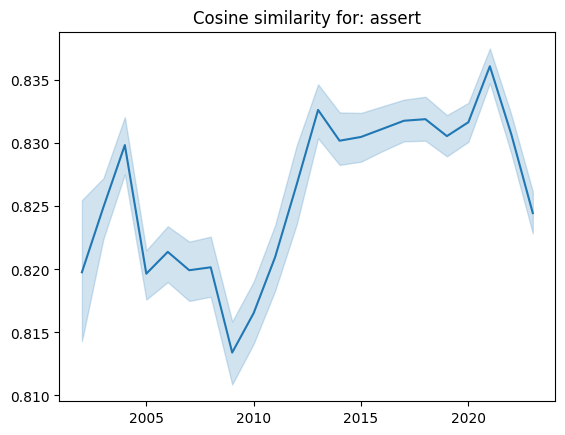

In [ ]:
viz_cos_sim("assert", fm_embeddings_df, fm_trim_df, "answer", "answer_lem")

## Loading US Data for Comparison ##



In [ ]:
nss_df = pd.read_csv("/content/drive/My Drive/2023-24/Academics/Research/Corpus/Files/nss.csv")
nss_trim_df = nss_df[["text", "year"]]

nss_source_indicator = []
for i in range(nss_trim_df.shape[0]):
  nss_source_indicator.append("nss")

nss_trim_df["source"] = nss_source_indicator


nss_trim_df.head()

<ipython-input-22-75094480c271>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nss_trim_df["source"] = nss_source_indicator


text  year source
0  The National\n\nSecurity Strategy\n\nof the \n...  2002    nss
1  


 \n\n \n\n \n\n \n\nTABLE OF CONTENTS \n\nO...  2006    nss
2  NAT IONA L  SECU R IT Y \n\nSTR ATEGY\n\nMay 2...  2010    nss
3  NATIONAL  SECURITY \n\nSTRATEGY\n\nF EBRUA RY ...  2015    nss
4  N������� S������� \n\nS�������\n\nof the Unite...  2017    nss

In [ ]:
frc_df = pd.read_csv("/content/drive/My Drive/2023-24/Academics/Research/Corpus/Files/frc.csv")
print(frc_df.shape, frc_df.dropna().shape)
frc_df = frc_df.dropna() #around 40% data loss
frc_year_list = []
for date in frc_df["date"]:
  frc_year_list.append(str(date)[-4:])

frc_df["year"] = frc_year_list
frc_df = frc_df[["text", "year"]]

frc_source_indicator = []
for i in range(frc_df.shape[0]):
  frc_source_indicator.append("frc")

frc_df["source"] = frc_source_indicator

frc_df.head()



(223, 3) (134, 3)


text  year source
0  CAN24357 416 \nS.L.C. \n118TH CONGRESS \n2D SE...  2024    frc
1   \nApril 9 2024 \n \nVladimir Kara Murza  \nIK...  2024    frc
2  DAV24502 KVP \nS.L.C. \n118TH CONGRESS \n2D SE...  2024    frc
3  II \n118TH CONGRESS \n2D SESSION \nS. 3854 \nT...  2024    frc
4  MDM24027 WSS \nS.L.C. \n118TH CONGRESS \n2D SE...  2024    frc

In [ ]:
tot_us_df = pd.concat([nss_trim_df, frc_df], axis=0).reset_index()

In [ ]:
tot_us_df.head(10)

index                                               text  year source
0      0  The National\n\nSecurity Strategy\n\nof the \n...  2002    nss
1      1  


 \n\n \n\n \n\n \n\nTABLE OF CONTENTS \n\nO...  2006    nss
2      2  NAT IONA L  SECU R IT Y \n\nSTR ATEGY\n\nMay 2...  2010    nss
3      3  NATIONAL  SECURITY \n\nSTRATEGY\n\nF EBRUA RY ...  2015    nss
4      4  N������� S������� \n\nS�������\n\nof the Unite...  2017    nss
5      5  NATIONAL\nSECURITY\nSTRATEGY\n\nOCTOBER 2022\n...  2022    nss
6      0  CAN24357 416 \nS.L.C. \n118TH CONGRESS \n2D SE...  2024    frc
7      1   \nApril 9 2024 \n \nVladimir Kara Murza  \nIK...  2024    frc
8      2  DAV24502 KVP \nS.L.C. \n118TH CONGRESS \n2D SE...  2024    frc
9      3  II \n118TH CONGRESS \n2D SESSION \nS. 3854 \nT...  2024    frc

In [ ]:
tot_us_df.tail()

index                                               text  year source
135    129  Obama Administration Draft \nMenendez / Corker...  2013    frc
136    130  Opening Statement \nSenator Richard G. Lugar \...  2012    frc
137    131  Committee Statement of Senator Lugar  \nUN Con...  2012    frc
138    132  UNCLASSIFIED\nNew START Inspection & Escort 10...  2010    frc
139    133  Witness Quotes from Senate Foreign Relations C...  2010    frc

In [ ]:
#cleaning and chunking into paragraphs
#it seems that a lot of the double \n\n are paragraphs, will check this somewhow
list_of_chunked_texts= []

for text in tot_us_df["text"]:
  list_of_paragraphs = text.split("\n\n")
  list_of_paragraphs_to_add = []
  for paragraph_index in range(len(list_of_paragraphs)): #some cleaning
    if len(list_of_paragraphs[paragraph_index].split(" ")) > 10: #removing paragraphs with less than or equal to 10 words
        list_of_paragraphs_to_add.append(list_of_paragraphs[paragraph_index].replace("\n", "")) #removing newline characters since they are very frequent)
  list_of_chunked_texts.append(list_of_paragraphs_to_add)


In [ ]:
list_of_chunked_texts[0][:5] #looks good!

['The great struggles of the twentieth century between liberty and totalitarianism ended with adecisive victory for the forces of freedom—and a single sustainable model for national success:freedom, democracy, and free enterprise. In the twenty-first century, only nations that share acommitment to protecting basic human rights and guaranteeing political and economicfreedom will be able to unleash the potential of their people and assure their future prosperity.People everywhere want to be able to speak freely; choose who will govern them; worship as theyplease; educate their children—male and female; own property; and enjoy the benefits of theirlabor. These values of freedom are right and true for every person, in every society—and theduty of protecting these values against their enemies is the common calling of freedom-lovingpeople across the globe and across the ages.',
 'Today, the United States enjoys a position of unparalleled military strength and great economicand political infl

In [ ]:
tot_us_df["chunked_texts"] = list_of_chunked_texts
tot_us_df.head()

index                                               text  year source  \
0      0  The National\n\nSecurity Strategy\n\nof the \n...  2002    nss   
1      1  


 \n\n \n\n \n\n \n\nTABLE OF CONTENTS \n\nO...  2006    nss   
2      2  NAT IONA L  SECU R IT Y \n\nSTR ATEGY\n\nMay 2...  2010    nss   
3      3  NATIONAL  SECURITY \n\nSTRATEGY\n\nF EBRUA RY ...  2015    nss   
4      4  N������� S������� \n\nS�������\n\nof the Unite...  2017    nss   

                                       chunked_texts  
0  [The great struggles of the twentieth century ...  
1  [Strengthen Alliances to Defeat Global Terrori...  
2  [I. Overview of National Security Strategy .  ...  
3  [Today, the United States is stronger and bett...  
4  [D E C E M B E R   2 0 1 7, W A S H I N G T O ...

In [ ]:
tot_year_list = []
tot_paragraph_list = []

#for i in range(len(tot_us_df["chunked_texts"])):
#  for j in range(len(tot_us_df["chunked_texts"][i])):
#    print(j)
#    print("newline")
#    tot_year_list.append(tot_us_df["year"][i])

num_paragraphs_per_text = []

for i in tot_us_df["chunked_texts"]:
  num_paragraphs_per_text.append(len(i))

for i in range(len(num_paragraphs_per_text)):
  for j in range(num_paragraphs_per_text[i]):
    tot_year_list.append(tot_us_df["year"][i])



#for i in range(len(tot_us_df["chunked_texts"])):
#  for j in range(len(tot_us_df["chunked_texts"][i])):
#    nss_filename_list.append(tot_us_df["file_name"][i])

print(tot_year_list[:5], tot_year_list[-5:])
#print(tot_filename_list[:5], tot_filename_list[-5:])

for i in list_of_chunked_texts:
  for j in i:
    tot_paragraph_list.append(j)

print(len(tot_year_list), len(tot_paragraph_list))

tot_paragraph_df = pd.DataFrame(data={"year": tot_year_list,
                                      "paragraph": tot_paragraph_list})

tot_paragraph_df.head()

[2002, 2002, 2002, 2002, 2002] ['2013', '2012', '2012', '2010', '2010']
1821 1821


year                                          paragraph
0  2002  The great struggles of the twentieth century b...
1  2002  Today, the United States enjoys a position of ...
2  2002  Defending our Nation against its enemies is th...
3  2002  To defeat this threat we must make use of ever...
4  2002  
to account nations that are compromised by te...

In [ ]:
#use different approach, use sentence model tokenizer instead
tot_embeddings = model.encode(tot_paragraph_df["paragraph"])




In [ ]:
print(tot_embeddings.shape)



(1821, 768)


In [ ]:
tot_umap_embeddings = reducer.fit_transform(tot_embeddings)

In [ ]:
tot_embeddings_meta_df = pd.DataFrame(data={"dim1" : tot_umap_embeddings[:,0],
                                           "dim2" : tot_umap_embeddings[:,1],
                                           "year" : tot_paragraph_df["year"],
                                           "id" : tot_paragraph_df.index})

alt.Chart(tot_embeddings_meta_df,
          # Title for plot / size of points
          title="Text Similarity").mark_circle(size=200).encode(
    alt.X('dim1',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(labels=False),
    ),
    alt.Y("dim2",
          axis=alt.Axis(labels=False)),
    # Color by label
    color = "year",
    tooltip=['year', 'id'],
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

In [ ]:
tot_embeddings_df = pd.DataFrame(data=tot_embeddings[0:,0:],
                                columns=np.arange(768))
tot_embeddings_df.shape

(1821, 768)

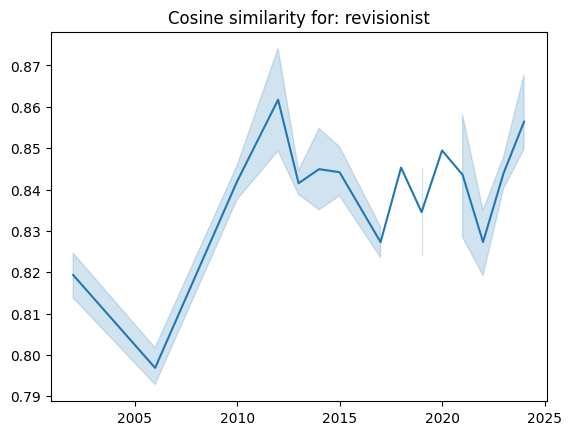

In [ ]:
viz_cos_sim("revisionist", tot_embeddings_df, tot_paragraph_df, "paragraph")

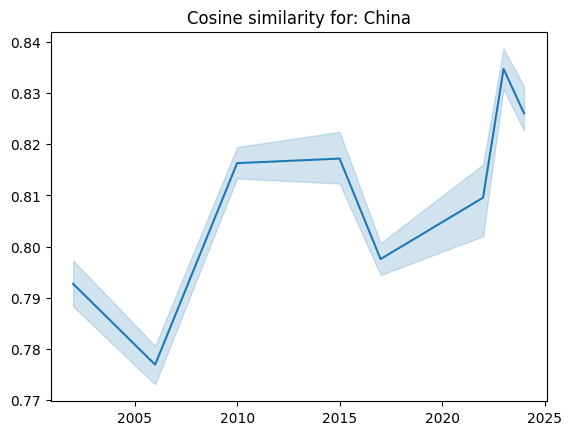

In [ ]:
viz_cos_sim("China", tot_embeddings_df, tot_paragraph_df, "paragraph")

In [ ]:
def get_cosine_similarity (phrase_to_avg, embeddings_df, text_df, column_name, extra_col_name=""):
  indices_list = []
  for i in range(len(text_df[column_name])):
    if phrase_to_avg in text_df[column_name][i] and i not in indices_list:
      indices_list.append(i)
  #for answer_lem as well just in case
  if len(extra_col_name) != 0:
    for i in range(len(text_df[extra_col_name])):
      if phrase_to_avg in text_df[extra_col_name][i] and i not in indices_list:
        indices_list.append(i)
  #get embeddings for indices_list
  embeddings_to_avg = embeddings_df.iloc[indices_list,:]
  avg_embedding = np.average(embeddings_to_avg, axis=0)
  embeddings_to_viz = embeddings_df.drop(indices_list) #probably wont work since not a pandas dataframe
  cosine_sim_list = []
  years_list = []
  years_to_cosine_sim_dict = {}
  for j in range(embeddings_to_viz.shape[0]):
    cosine_sim_list.append(np.dot(avg_embedding, embeddings_to_viz.iloc[j,:]))
    years_list.append(text_df["year"][j])
  for k in range(len(years_list)):
    years_to_cosine_sim_dict[years_list[k]] = cosine_sim_list[k]
  return (years_to_cosine_sim_dict)

In [ ]:
def compare_cosine_similarity (us_word, cn_word):
  us_dict = get_cosine_similarity(us_word, tot_embeddings_df, tot_paragraph_df, "paragraph")
  cn_dict = get_cosine_similarity(cn_word, fm_embeddings_df, fm_trim_df, "answer", "answer_lem")
  #stratify by year
  unified_year = []
  for i in us_dict.keys():
    if i in cn_dict.keys():
      if i not in unified_year:
        unified_year.append(i)
  #compute correlation
  us_cossims_to_correlate = []
  cn_cossims_to_correlate = []
  correlations_dict = {}
  for year_value in unified_year:
    correlations_dict[year_value] = (us_dict[year_value] - cn_dict[year_value])
    us_cossims_to_correlate.append(us_dict[year_value])
    cn_cossims_to_correlate.append(cn_dict[year_value])

  #outputs for relationship
  fig = sns.lineplot(x=correlations_dict.keys(), y=correlations_dict.values()).set_title("Relationship between: " + us_word + " (U.S. Word) and " + cn_word + " (China Word)")
  plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x))) #inspired by: https://stackoverflow.com/questions/30327153/seaborn-changing-xticks-from-float-to-int
  plt.xlabel("Year", fontsize=8)
  plt.ylabel("U.S Word Cosine Similarity - China Word Cosine Similarity", fontsize=8)
  plt.show(fig) #inspired by https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot
  print("Correlation Over Time: " + str(np.round(pearsonr(us_cossims_to_correlate, cn_cossims_to_correlate).statistic, 4)))
  print("---")

  #create dataframe to compare cosine similarities over time
  comparison_years = []
  year_indicator = []
  country_indicator = []
  us_cn_values = []

  us_keys = list(us_dict.keys())
  cn_keys = list(cn_dict.keys())
  tot_keys = us_keys + cn_keys

  for year_value in tot_keys:
    if year_value not in comparison_years:
      comparison_years.append(year_value)

  for year_value in comparison_years:
    if year_value in us_dict.keys():
      us_cn_values.append(us_dict[year_value])
      year_indicator.append(year_value)
      country_indicator.append("US")
    if year_value in cn_dict.keys():
      us_cn_values.append(cn_dict[year_value])
      year_indicator.append(year_value)
      country_indicator.append("CN")

  comparative_cossim_df = pd.DataFrame(data= {"year": year_indicator, "country": country_indicator, "cosine_similarity": us_cn_values})
  fig = sns.lineplot(x="year", y="cosine_similarity", hue="country", data= comparative_cossim_df, errorbar="se").set_title("Cosine Similarities for: " + us_word + " (U.S. Word) and " + cn_word + " (China Word)")
  plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
  plt.xlabel("Year", fontsize=8)
  plt.ylabel("Cosine Similarity for Respective Words", fontsize=8)
  plt.show(fig)



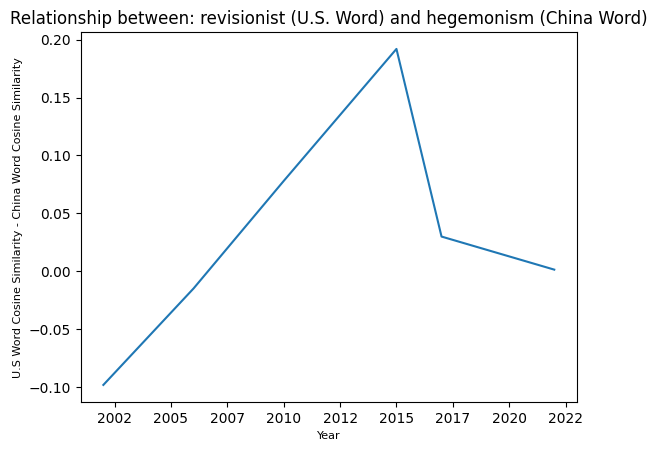

Correlation Over Time: -0.1915
---


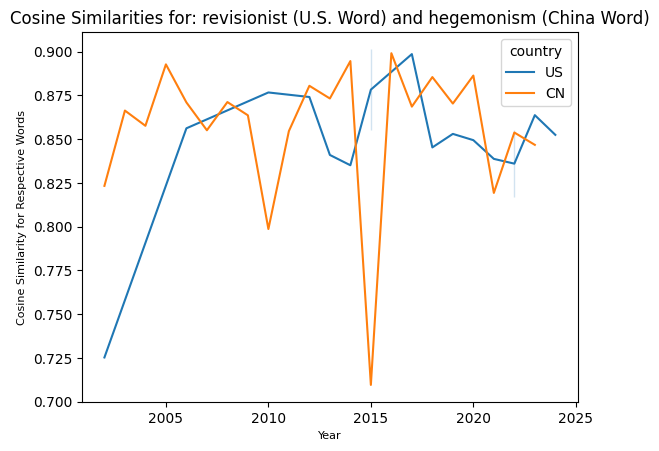

In [ ]:
compare_cosine_similarity("revisionist", "hegemonism")

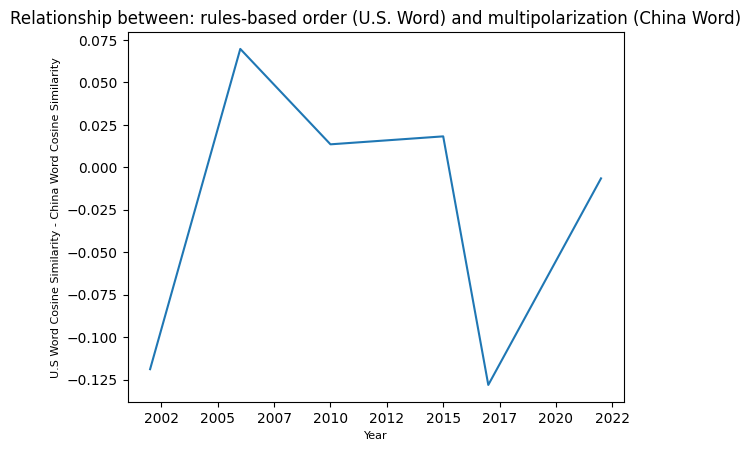

Correlation Over Time: 0.1306
---


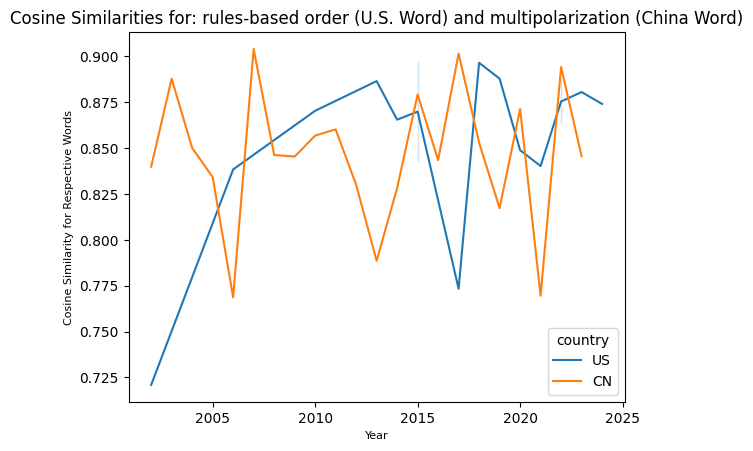

In [ ]:
compare_cosine_similarity("rules-based order", "multipolarization")

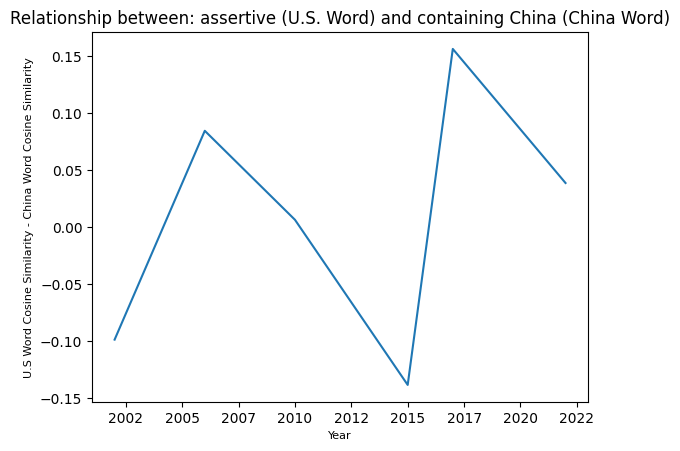

Correlation Over Time: -0.6362
---


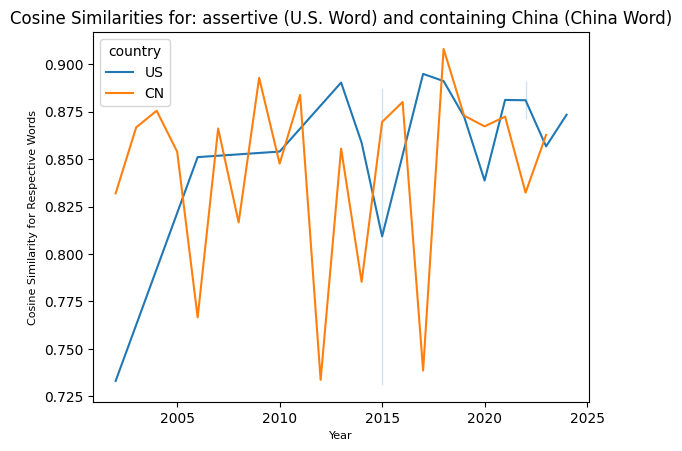

In [ ]:
compare_cosine_similarity("assertive", "containing China")

In [ ]:
def get_cosine_similarity_distribution (phrase_to_avg, embeddings_df, text_df, column_name, cutoff_year, extra_col_name=""):
  indices_list = []
  for i in range(len(text_df[column_name])):
    if phrase_to_avg in text_df[column_name][i] and i not in indices_list:
      indices_list.append(i)
  #for answer_lem as well just in case
  if len(extra_col_name) != 0:
    for i in range(len(text_df[extra_col_name])):
      if phrase_to_avg in text_df[extra_col_name][i] and i not in indices_list:
        indices_list.append(i)
  #get embeddings for indices_list
  embeddings_to_avg = embeddings_df.iloc[indices_list,:]
  avg_embedding = np.average(embeddings_to_avg, axis=0)
  embeddings_to_calculate = embeddings_df.drop(indices_list) #probably wont work since not a pandas dataframe
  cosine_sim_list = []
  years_list = []
  for j in range(embeddings_to_calculate.shape[0]):
    cosine_sim_list.append(np.dot(avg_embedding, embeddings_to_calculate.iloc[j,:]))
    years_list.append(int(text_df["year"][j]))
  firstbin_sim = cosine_sim_list[:years_list.index(cutoff_year)]
  firstbin_median_sim = np.median(cosine_sim_list[:years_list.index(cutoff_year)])
  firstbin_std_sim = np.std(cosine_sim_list[:years_list.index(cutoff_year)])
  secondbin_sim = cosine_sim_list[years_list.index(cutoff_year):]
  secondbin_median_sim = np.median(cosine_sim_list[years_list.index(cutoff_year):])
  secondbin_std_sim = np.std(cosine_sim_list[years_list.index(cutoff_year):])
  return(firstbin_sim, firstbin_median_sim, firstbin_std_sim, secondbin_sim, secondbin_median_sim, secondbin_std_sim)

In [ ]:
def compare_two_bins(country, word, comparison_year):
  print("Testing " + word + " for country " + country + " with bin separation at year " + str(comparison_year))
  if country == "us":
    firstbin_sim, firstbin_median_sim, firstbin_std_sim, secondbin_sim, secondbin_median_sim, secondbin_std_sim = get_cosine_similarity_distribution (word, tot_embeddings_df, tot_paragraph_df, "paragraph", comparison_year)
  else:
    firstbin_sim, firstbin_median_sim, firstbin_std_sim, secondbin_sim, secondbin_median_sim, secondbin_std_sim = get_cosine_similarity_distribution (word, fm_embeddings_df, fm_trim_df, "answer", comparison_year, "answer_lem")

  ttest_result = ttest_ind(firstbin_sim, secondbin_sim)
  return(ttest_result)







In [ ]:
compare_two_bins("us", "revisionist", 2015)

Testing revisionist for country us with bin separation at year 2015


TtestResult(statistic=-6.762582973923034, pvalue=1.8212599547525067e-11, df=1817.0)

In [ ]:
unique_year_list = tot_us_df["year"].unique()
unique_year_list_clean = []
for year_value in unique_year_list:
  if int(year_value) not in unique_year_list_clean:
    unique_year_list_clean.append(int(year_value))

unique_year_list_clean.sort()

print(unique_year_list_clean)

[2002, 2006, 2010, 2012, 2013, 2014, 2015, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [ ]:
for year_value in unique_year_list_clean:
  print(year_value)
  print(compare_two_bins("us", "revisionist", year_value))
  print("------")

2002
Testing revisionist for country us with bin separation at year 2002


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing revisionist for country us with bin separation at year 2006
TtestResult(statistic=-2.112178442930408, pvalue=0.034807284450381046, df=1817.0)
------
2010
Testing revisionist for country us with bin separation at year 2010
TtestResult(statistic=-13.952022420162, pvalue=4.187619003884594e-42, df=1817.0)
------
2012
Testing revisionist for country us with bin separation at year 2012
TtestResult(statistic=-1.1630687260030943, pvalue=0.2449543399313826, df=1817.0)
------
2013
Testing revisionist for country us with bin separation at year 2013
TtestResult(statistic=-1.3219469230104757, pvalue=0.18635222356813738, df=1817.0)
------
2014
Testing revisionist for country us with bin separation at year 2014
TtestResult(statistic=-1.5953019775851154, pvalue=0.11081862896839902, df=1817.0)
------
2015
Testing revisionist for country us with bin separation at year 2015
TtestResult(statistic=-6.762582973923034, pvalue=1.82125995475250

In [ ]:
for year_value in unique_year_list_clean:
  if year_value != 2012: #no data for this specific meme for that year potentially
    print(year_value)
    print(compare_two_bins("us", "rules-based order", year_value))
    print("------")

2002
Testing rules-based order for country us with bin separation at year 2002


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing rules-based order for country us with bin separation at year 2006
TtestResult(statistic=-4.645592086254807, pvalue=3.6350794699350923e-06, df=1814.0)
------
2010
Testing rules-based order for country us with bin separation at year 2010
TtestResult(statistic=-17.061523969442884, pvalue=1.1944649561103691e-60, df=1814.0)
------
2013
Testing rules-based order for country us with bin separation at year 2013
TtestResult(statistic=-2.470086008729747, pvalue=0.013599458115230846, df=1814.0)
------
2014
Testing rules-based order for country us with bin separation at year 2014
TtestResult(statistic=-2.786952806303807, pvalue=0.005376045992410723, df=1814.0)
------
2015
Testing rules-based order for country us with bin separation at year 2015
TtestResult(statistic=-7.876691653911402, pvalue=5.742051651390689e-15, df=1814.0)
------
2017
Testing rules-based order for country us with bin separation at year 2017
TtestResult(statistic

In [ ]:
for year_value in unique_year_list_clean:
    if year_value != 2012:
      print(year_value)
      print(compare_two_bins("us", "assertive", year_value))
      print("------")

2002
Testing assertive for country us with bin separation at year 2002
TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing assertive for country us with bin separation at year 2006


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=-4.430272860999325, pvalue=9.973030432320164e-06, df=1815.0)
------
2010
Testing assertive for country us with bin separation at year 2010
TtestResult(statistic=-16.3616084811543, pvalue=3.109545302549556e-56, df=1815.0)
------
2013
Testing assertive for country us with bin separation at year 2013
TtestResult(statistic=-3.156512670639987, pvalue=0.0016228984422678382, df=1815.0)
------
2014
Testing assertive for country us with bin separation at year 2014
TtestResult(statistic=-3.4612998097909036, pvalue=0.0005500223442270409, df=1815.0)
------
2015
Testing assertive for country us with bin separation at year 2015
TtestResult(statistic=-8.338843918833701, pvalue=1.4633765006422845e-16, df=1815.0)
------
2017
Testing assertive for country us with bin separation at year 2017
TtestResult(statistic=-4.965147593767047, pvalue=7.508409743343966e-07, df=1815.0)
------
2018
Testing assertive for country us with bin separation at year 2018
TtestResult(statistic=-4.13818963

In [ ]:
for year_value in unique_year_list_clean:
  if year_value != 2024: #no data for 2024 for China narratives
    print(year_value)
    print(compare_two_bins("cn", "hegemonism", year_value))
    print("------")

2002
Testing hegemonism for country cn with bin separation at year 2002


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing hegemonism for country cn with bin separation at year 2006
TtestResult(statistic=-5.893270189315663, pvalue=3.825464940681534e-09, df=30921.0)
------
2010
Testing hegemonism for country cn with bin separation at year 2010
TtestResult(statistic=-15.951809446228955, pvalue=4.6773394384856573e-57, df=30921.0)
------
2012
Testing hegemonism for country cn with bin separation at year 2012
TtestResult(statistic=-19.519467476648604, pvalue=2.417651658416455e-84, df=30921.0)
------
2013
Testing hegemonism for country cn with bin separation at year 2013
TtestResult(statistic=-19.856640168731435, pvalue=3.3792122596963033e-87, df=30921.0)
------
2014
Testing hegemonism for country cn with bin separation at year 2014
TtestResult(statistic=-18.42257379320991, pvalue=2.1945200032802507e-75, df=30921.0)
------
2015
Testing hegemonism for country cn with bin separation at year 2015
TtestResult(statistic=-17.72991412353176, pvalue=5.47

In [ ]:
for year_value in unique_year_list_clean:
    if year_value != 2024:
      print(year_value)
      print(compare_two_bins("cn", "multipolarization", year_value))
      print("------")

2002
Testing multipolarization for country cn with bin separation at year 2002


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing multipolarization for country cn with bin separation at year 2006
TtestResult(statistic=-3.065344659468801, pvalue=0.0021760644561599363, df=30956.0)
------
2010
Testing multipolarization for country cn with bin separation at year 2010
TtestResult(statistic=-10.2585665019192, pvalue=1.1861197734202025e-24, df=30956.0)
------
2012
Testing multipolarization for country cn with bin separation at year 2012
TtestResult(statistic=-12.22171927151784, pvalue=2.8550773832670036e-34, df=30956.0)
------
2013
Testing multipolarization for country cn with bin separation at year 2013
TtestResult(statistic=-12.357719441759818, pvalue=5.352292923736055e-35, df=30956.0)
------
2014
Testing multipolarization for country cn with bin separation at year 2014
TtestResult(statistic=-10.718533074379392, pvalue=9.283237470009013e-27, df=30956.0)
------
2015
Testing multipolarization for country cn with bin separation at year 2015
TtestResult(st

In [ ]:
for year_value in unique_year_list_clean:
    if year_value != 2024:
      print(year_value)
      print(compare_two_bins("cn", "containing China", year_value))
      print("------")

2002
Testing containing China for country cn with bin separation at year 2002


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TtestResult(statistic=nan, pvalue=nan, df=nan)
------
2006
Testing containing China for country cn with bin separation at year 2006
TtestResult(statistic=-7.301056876795142, pvalue=2.9239232462740336e-13, df=30925.0)
------
2010
Testing containing China for country cn with bin separation at year 2010
TtestResult(statistic=-18.02649084171346, pvalue=2.8325543752550133e-72, df=30925.0)
------
2012
Testing containing China for country cn with bin separation at year 2012
TtestResult(statistic=-22.067606246072792, pvalue=4.349575922001968e-107, df=30925.0)
------
2013
Testing containing China for country cn with bin separation at year 2013
TtestResult(statistic=-22.186650849321865, pvalue=3.2359671254632743e-108, df=30925.0)
------
2014
Testing containing China for country cn with bin separation at year 2014
TtestResult(statistic=-20.83084581464219, pvalue=1.0346028881245622e-95, df=30925.0)
------
2015
Testing containing China for country cn with bin separation at year 2015
TtestResult(sta